In [2]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torch
from torchvision import models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pdB
from sklearn.metrics import roc_auc_score, auc, roc_curve
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import datasets, transforms
from shutil import rmtree, copytree, copyfile
import random
import warnings
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [3]:
class InceptionV3(nn.Module):
  def __init__(self, num_classes = 2):
    super(InceptionV3, self).__init__()
    model = models.inception_v3(pretrained=True)
    self.Conv2d_1a_3x3 = model.Conv2d_1a_3x3
    self.Conv2d_2a_3x3 = model.Conv2d_2a_3x3
    self.Conv2d_2b_3x3 = model.Conv2d_2b_3x3
    self.Conv2d_3b_1x1 = model.Conv2d_3b_1x1
    self.Conv2d_4a_3x3 = model.Conv2d_4a_3x3
    self.Mixed_5b = model.Mixed_5b
    self.Mixed_5c = model.Mixed_5c
    self.Mixed_5d = model.Mixed_5d
    self.Mixed_6a = model.Mixed_6a
    self.Mixed_6b = model.Mixed_6b
    self.Mixed_6c = model.Mixed_6c
    self.Mixed_6d = model.Mixed_6d
    self.Mixed_6e = model.Mixed_6e
    self.Mixed_7a = model.Mixed_7a
    self.Mixed_7b = model.Mixed_7b
    self.Mixed_7c = model.Mixed_7c

    self.dropout = nn.Dropout(p=0.5)
    self.fc = nn.Linear(2048, num_classes)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

  def forward(self, x):
      features = None
      x = nn.Upsample(size=(299, 299), mode='bilinear')(x)
      x = self.Conv2d_1a_3x3(x)
      x = self.Conv2d_2a_3x3(x)
      x = self.Conv2d_2b_3x3(x)
      x = F.max_pool2d(x, kernel_size=3, stride=2)
      x = self.Conv2d_3b_1x1(x)
      x = self.Conv2d_4a_3x3(x)

      x = F.max_pool2d(x, kernel_size=3, stride=2)
      x = self.Mixed_5b(x)
      x = self.Mixed_5c(x)
      x = self.Mixed_5d(x)

      x = self.Mixed_6a(x)
      x = self.Mixed_6b(x)
      x = self.Mixed_6c(x)
      x = self.Mixed_6d(x)
      x = self.Mixed_6e(x)

      # image region features
      features = x

      x = self.Mixed_7a(x)
      x = self.Mixed_7b(x)
      x = self.Mixed_7c(x)
      x = self.avgpool(x)
      x = self.dropout(x)
      x = x.view(x.size(0), -1)

      x = self.fc(x)
      return x 

In [4]:
class Resnet34(nn.Module):
  def __init__(self, num_classes = 2):
    super(Resnet34, self).__init__()
    model = models.resnet34(pretrained=True)
    self.conv1 = model.conv1
    self.bn1 = model.bn1
    self.relu = model.relu
    self.maxpool = model.maxpool
    self.layer1 = model.layer1
    self.layer2 = model.layer2
    self.layer3 = model.layer3
    self.layer4 = model.layer4
    self.avgpool = model.avgpool
    self.__in_features = model.fc.in_features
    self.fc = nn.Linear(512, num_classes)
    # self.softmax = nn.Softmax()
  def forward(self, x):

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    # x = self.softmax(x)
    return x

  def output_num(self):
    return self.__in_features

In [5]:
class Densnet121(nn.Module):
  def __init__(self, num_classes = 2):
    super(Densnet121, self).__init__()
    model = models.densenet121(pretrained=True)
    self.features = model.features
    self.fc = nn.Linear(1024, num_classes)
    self.relu_out = 0

  def forward(self, x):
    features = self.features(x)
    out = F.relu(features, inplace=True)
    self.relu_out = out
    out = F.avg_pool2d(out, kernel_size=7, stride=1).view(features.size(0), -1)
    out = self.fc(out)
    return out

  def cam_out(self):
      return self.relu_out

In [6]:
source_name = "train"
target_name = "val"
batch_size = 8
epochs = 20
lr = 0.01
momentum = 0.8
no_cuda = False
seed = 8
log_interval = 10
l2_decay = 5e-4
random_seed = 80
split_train_ratio=0.2
path="drive/MyDrive/Thyroid"

In [7]:
def split_data():
    for name in [source_name, target_name]:
        if os.path.exists(os.path.join(path, name)):
            rmtree(os.path.join(path, name))
            os.makedirs(os.path.join(path, name))
        else:
            os.makedirs(os.path.join(path, name))

    tmp = os.listdir(path)
    tmp = [i for i in tmp if i not in [source_name, target_name]]
    for properties in tmp:
        files = os.listdir(os.path.join(path, properties))
        random.seed(random_seed)
        random.shuffle(files)
        for file in files[: int(len(files) * split_train_ratio)]:
            if not os.path.exists(os.path.join(path, 'train', properties)):
                os.makedirs(os.path.join(path, 'train', properties))
            copyfile(os.path.join(path, properties, file),
                     os.path.join(path, 'train', properties, file)
                     )
        for file in files[int(len(files) * split_train_ratio):]:
            if not os.path.exists(os.path.join(path, 'val', properties)):
                os.makedirs(os.path.join(path, 'val', properties))
            copyfile(os.path.join(path, properties, file),
                     os.path.join(path, 'val', properties, file)
                     )
    print('complete data split')

In [8]:
 split_data()

complete data split


In [9]:
import time

def train(model, train_dl, val_dl, epochs=100, device='cpu'):


    history = {} # Collects per-epoch loss and acc like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []

    start_time_sec = time.time()

    for epoch in range(1, epochs+1):
        LEARNING_RATE = max(lr * (0.1 ** (epochs // 100)), 1e-5)
        optimizer = torch.optim.SGD([{'params': model.parameters()}], lr=LEARNING_RATE, momentum=momentum, weight_decay=l2_decay)

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        for batch in train_dl:

            optimizer.zero_grad()

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            optimizer.zero_grad()
            loss = F.nll_loss(F.log_softmax(yhat, dim=1), y)

            loss.backward()
            optimizer.step()

            train_loss         += loss.data.item() * x.size(0)
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        val_loss       = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in val_dl:

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss=F.nll_loss(F.log_softmax(yhat, dim=1), y, size_average=False)

            val_loss         += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)


        if epoch == 1 or epoch % 10 == 0:
          print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
                (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # END OF TRAINING LOOP


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history

def plot_loss(history, model_name):
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title(model_name +' Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def plot_accuracy(history, model_name):
  plt.plot(history['acc'])
  plt.plot(history['val_acc'])
  plt.title(model_name +' Accuracy')
  plt.ylabel('acc')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [10]:
cuda = not no_cuda and torch.cuda.is_available()
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}

In [11]:
def load_training(root_path, dir, batch_size, kwargs):
    transform = transforms.Compose(
        [transforms.Resize([256, 256]),
         transforms.RandomRotation(15),
         transforms.ColorJitter(),
         transforms.RandomCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.RandomVerticalFlip(),
         transforms.ToTensor()
         ])
    data = datasets.ImageFolder(root=os.path.join(root_path, dir), transform=transform)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)
    return train_loader

def load_testing(root_path, dir, batch_size, kwargs):

    transform = transforms.Compose(
        [transforms.Resize([224, 224]),
         transforms.ToTensor()])
    data = datasets.ImageFolder(root=os.path.join(root_path, dir), transform=transform)
    # print(list(data.imgs))
    names = list(map(lambda x: os.path.basename(x[0]), list(data.imgs)))
    label = list(map(lambda x: x[1], list(data.imgs)))
    # print(names, label)
    # for name, label in data.imgs:
    #     print(name, label)
    test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False, **kwargs)
    return test_loader, names, label

In [12]:
num_classes = len(os.listdir(os.path.join(path, source_name)))
source_loader = load_training(path, source_name, batch_size, kwargs)
target_test_loader, names, label = load_testing(path, target_name, batch_size, kwargs)

len_source_dataset = len(source_loader.dataset)
len_target_dataset = len(target_test_loader.dataset)
len_source_loader = len(source_loader)

In [13]:
model_inc = InceptionV3(num_classes=num_classes)
model_inc.cuda()
history_inc=train(model_inc, source_loader, target_test_loader, epochs=20, device='cuda')

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Epoch   1/ 20, train loss:  0.72, train acc:  0.58, val loss:  5.49, val acc:  0.58
Epoch  10/ 20, train loss:  0.29, train acc:  0.85, val loss:  6.53, val acc:  0.65
Epoch  20/ 20, train loss:  0.13, train acc:  0.96, val loss:  5.53, val acc:  0.73

Time total:     64.76 sec
Time per epoch:  3.24 sec


In [14]:
model_res=Resnet34(num_classes=num_classes)
model_res.cuda()
history_res=train(model_res, source_loader, target_test_loader, epochs=20, device='cuda')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Epoch   1/ 20, train loss:  0.70, train acc:  0.62, val loss:  5.37, val acc:  0.63
Epoch  10/ 20, train loss:  0.64, train acc:  0.79, val loss: 13.26, val acc:  0.59
Epoch  20/ 20, train loss:  0.10, train acc:  0.98, val loss:  6.91, val acc:  0.72

Time total:     49.52 sec
Time per epoch:  2.48 sec


In [15]:
model_dense=Densnet121(num_classes=num_classes)
model_dense.cuda()
history_dense=train(model_dense, source_loader, target_test_loader, epochs=20, device='cuda')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Epoch   1/ 20, train loss:  0.85, train acc:  0.46, val loss:  4.95, val acc:  0.61
Epoch  10/ 20, train loss:  0.36, train acc:  0.88, val loss: 18.77, val acc:  0.68
Epoch  20/ 20, train loss:  0.14, train acc:  0.90, val loss:  7.55, val acc:  0.80

Time total:     60.20 sec
Time per epoch:  3.01 sec


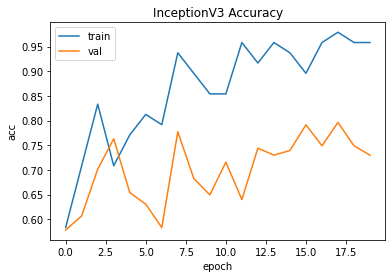

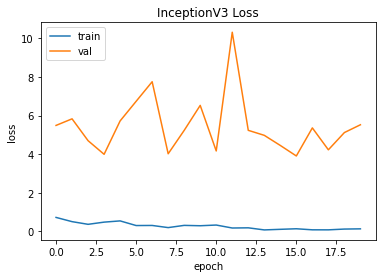

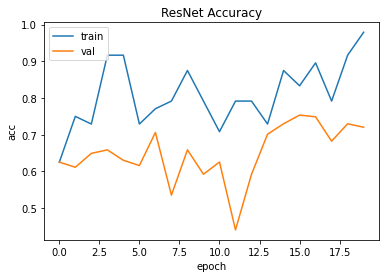

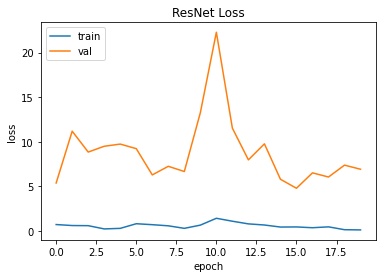

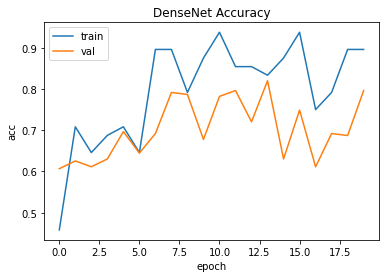

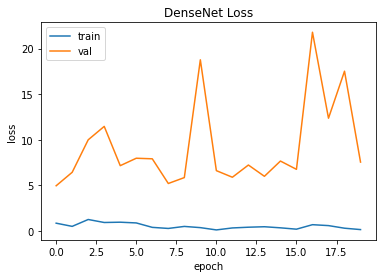

In [16]:
plot_accuracy(history_inc, 'InceptionV3')
plot_loss(history_inc, 'InceptionV3')
plot_accuracy(history_res, 'ResNet')
plot_loss(history_res, 'ResNet')
plot_accuracy(history_dense, 'DenseNet')
plot_loss(history_dense, 'DenseNet')

In [17]:
def output(model, data):
    model.eval()
    s_output = model(data)
    M_possibility = float(F.softmax(s_output).data.cpu().numpy()[0][1])
    return M_possibility


def get_result_by_model(image, model):
    result = output(model, image)

    if result >= .5:
        return 1
    else:
        return 0

def get_result_tirads(image):
    result = (.2)*output(model_inc, image)  + (.2)*output(model_res, image) + (.2)*output(model_dense, image)
    if result >= 0.35:
        return 1
    else:
        return 0

def get_pytorch_image(name):
    transform = transforms.Compose(
        [transforms.Resize([224, 224]),
         transforms.ToTensor()])
    image = Image.open(name)
    image = image.convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.cuda()
    return image

In [18]:
test_load, name1, label1 = load_testing(path, 'val', batch_size, kwargs)

In [19]:
pred_label=[]
for n,l in zip(name1,label1):
  if l==0:
    img=path+'/val/0/'+n;
  else:
    img=path+'/val/1/'+n;
  img=get_pytorch_image(img)
  temp=get_result_by_model(img, model_inc)
  pred_label.append(temp)


from sklearn.metrics import accuracy_score,average_precision_score, f1_score,recall_score, precision_score
acc=accuracy_score(label1,pred_label)
f1=f1_score(label1,pred_label)
re=recall_score(label1,pred_label)
pre=precision_score(label1,pred_label)

print(acc)
print(f1)
print(re)
print(pre)

0.7298578199052133
0.6984126984126984
0.8048780487804879
0.616822429906542


In [21]:
pred_label=[]
for n,l in zip(name1,label1):
  if l==0:
    img=path+'/val/0/'+n;
  else:
    img=path+'/val/1/'+n;
  img=get_pytorch_image(img)
  temp=get_result_by_model(img, model_dense)
  pred_label.append(temp)

from sklearn.metrics import accuracy_score,average_precision_score, f1_score,recall_score, precision_score
acc=accuracy_score(label1,pred_label)
f1=f1_score(label1,pred_label)
re=recall_score(label1,pred_label)
pre=precision_score(label1,pred_label)

print(acc)
print(f1)
print(re)
print(pre)

0.7962085308056872
0.7361963190184049
0.7317073170731707
0.7407407407407407


In [22]:
pred_label=[]
for n,l in zip(name1,label1):
  if l==0:
    img=path+'/val/0/'+n;
  else:
    img=path+'/val/1/'+n;
  img=get_pytorch_image(img)
  temp=get_result_by_model(img, model_res)
  pred_label.append(temp)

from sklearn.metrics import accuracy_score,average_precision_score, f1_score,recall_score, precision_score
acc=accuracy_score(label1,pred_label)
f1=f1_score(label1,pred_label)
re=recall_score(label1,pred_label)
pre=precision_score(label1,pred_label)

print(acc)
print(f1)
print(re)
print(pre)

0.7203791469194313
0.5815602836879433
0.5
0.6949152542372882
